In [1]:
import numpy as np 
import pandas as pd

In [2]:
!python -m pip install fipy


  Obtaining dependency information for fipy from https://files.pythonhosted.org/packages/3c/90/35015c5e45573144c8c05fc4ce559316205b128eb32fa8126f16f6deb6ea/FiPy-3.4.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 14.6 MB/s eta 0:00:00


In [3]:
import math
import numpy as np
import  scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from fipy import Variable, FaceVariable, CellVariable, Grid1D, Grid2D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm,ImplicitSourceTerm
from fipy.tools import numerix
from fipy.viewers.matplotlibViewer.matplotlib1DViewer import Matplotlib1DViewer as Viewer1D
from fipy.viewers.matplotlibViewer.matplotlib2DViewer import Matplotlib2DViewer as Viewer2D


In [4]:
#1) parameters
omega_0 = 1
g= 0.1 * omega_0
F = 0.1 *omega_0
#gamma= 0.05 *omega_0
gamma= omega_0

#2) mesh
nx=ny=50
dx=0.1
dy=0.1
mesh = Grid2D(nx=nx,ny=ny,dx=dx,dy=dy)

#y = CellVariable(mesh=mesh)
#x = CellVariable(mesh=mesh)
x = mesh.x
y = mesh.y
#TODO: figure out why hasold has to be true, and why in simpler examples its not specified
chiR11 = CellVariable(name=r"$Re(\chi_{11})$", mesh=mesh, hasOld=True)
chiR10 = CellVariable(name=r"$Re(\chi_{10})$", mesh=mesh, hasOld=True)
chiR01 = CellVariable(name=r"$Re(\chi_{01})$", mesh=mesh, hasOld=True)
chiR00 = CellVariable(name=r"$Re(\chi_{00})$", mesh=mesh, hasOld=True)

chiI11 = CellVariable(name=r"$Im(\chi_{11})$", mesh=mesh, hasOld=True)
chiI10 = CellVariable(name=r"$Im(\chi_{10})$", mesh=mesh, hasOld=True)
chiI01 = CellVariable(name=r"$Im(\chi_{01})$", mesh=mesh, hasOld=True)
chiI00 = CellVariable(name=r"$Im(\chi_{00})$", mesh=mesh, hasOld=True)


In [5]:
#boundary conditions
chiR11.constrain(0., where=mesh.facesTop)
chiR11.constrain(0., where=mesh.facesBottom)
chiR11.constrain(0., where=mesh.facesLeft)
chiR11.constrain(0., where=mesh.facesRight)

chiR10.constrain(0., where=mesh.facesTop)
chiR10.constrain(0., where=mesh.facesBottom)
chiR10.constrain(0., where=mesh.facesLeft)
chiR10.constrain(0., where=mesh.facesRight)

chiR01.constrain(0., where=mesh.facesTop)
chiR01.constrain(0., where=mesh.facesBottom)
chiR01.constrain(0., where=mesh.facesLeft)
chiR01.constrain(0., where=mesh.facesRight)

chiR00.constrain(0., where=mesh.facesTop)
chiR00.constrain(0., where=mesh.facesBottom)
chiR00.constrain(0., where=mesh.facesLeft)
chiR00.constrain(0., where=mesh.facesRight)

chiI11.constrain(0., where=mesh.facesTop)
chiI11.constrain(0., where=mesh.facesBottom)
chiI11.constrain(0., where=mesh.facesLeft)
chiI11.constrain(0., where=mesh.facesRight)

chiI10.constrain(0., where=mesh.facesTop)
chiI10.constrain(0., where=mesh.facesBottom)
chiI10.constrain(0., where=mesh.facesLeft)
chiI10.constrain(0., where=mesh.facesRight)

chiI01.constrain(0., where=mesh.facesTop)
chiI01.constrain(0., where=mesh.facesBottom)
chiI01.constrain(0., where=mesh.facesLeft)
chiI01.constrain(0., where=mesh.facesRight)

chiI00.constrain(0., where=mesh.facesTop)
chiI00.constrain(0., where=mesh.facesBottom)
chiI00.constrain(0., where=mesh.facesLeft)
chiI00.constrain(0., where=mesh.facesRight)


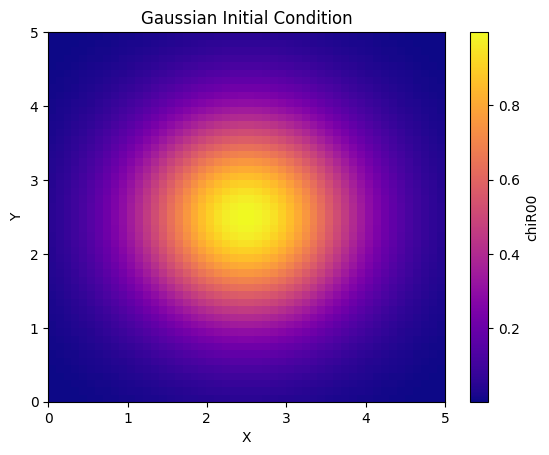

In [6]:
# Set the Gaussian initial condition
mean = [nx * dx / 2, ny * dy / 2]  # Center of the Gaussian surface
covariance = [[1, 0], [0,1]]  # Covariance matrix

#mean = [0,0]  
#covariance = [[0.0007, 0], [0, 0.0007]]  
#Generate coordinates for the grid
X, Y = mesh.cellCenters[0], mesh.cellCenters[1]

# Evaluate the Gaussian surface
gaussian_surface = multivariate_normal(mean=mean, cov=covariance)
Z = np.zeros_like(X)
Xm=X.value.reshape([nx,ny])
Ym=Y.value.reshape([nx,ny])

Z = gaussian_surface.pdf(np.column_stack((X.value.flat, Y.value.flat)))
#Z /= Z.max()

# Assign the Gaussian surface to the cell variable
chiR00.setValue(2*math.pi*Z)

plt.pcolor(Xm,Ym,chiR00.value.reshape((nx, ny)), cmap='plasma')

plt.colorbar(label='chiR00')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Initial Condition')
plt.show()


In [7]:
index_where_1 = np.where(Z ==Z.max())
index_where_1

(array([1224, 1225, 1274, 1275]),)

In [8]:
eq1R = TransientTerm(var=chiR00) == 2*F*(x-(nx*dx)/2)*chiI00+1/4*g*numerix.square(x-(nx*dx)/2)*chiI01-1/4*g*numerix.square(y-(ny*dy)/2)*chiI01-1/4*g*numerix.square(x-(nx*dx)/2)*chiI10+1/4*g*numerix.square(y-(ny*dy)/2)*chiI10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR00+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR00-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR10-1/2*g*(y-(ny*dy)/2)*chiI01.grad[1]+1/2*g*(y-(ny*dy)/2)*chiI10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR00.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR10.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI01.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI10.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI01.grad[0]-1/2*g*(x-(nx*dx)/2)*chiI10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*(chiR00.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiR01.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiR10.grad[0])-1/2*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[0]
eq1I =TransientTerm(var=chiI00) == 1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI00+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI00-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI10-2*F*(x-(nx*dx)/2)*chiR00-1/4*g*numerix.square(x-(nx*dx)/2)*chiR01+1/4*g*numerix.square(y-(ny*dy)/2)*chiR01+1/4*g*numerix.square(x-(nx*dx)/2)*chiR10-1/4*g*numerix.square(y-(ny*dy)/2)*chiR10+1/2*gamma*(y-(ny*dy)/2)*chiI00.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI10.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR01.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR10.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR01.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR10.faceValue).divergence.grad[1]+1/2*gamma*(x-(nx*dx)/2)*(chiI00.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiI01.grad[0])-1/2*g*(y-(ny*dy)/2)*chiI10.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR10.grad[0]-1/2*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[0]

eq2R =TransientTerm(var=chiR10) == -(1/4)*g*numerix.square(x-(nx*dx)/2)*chiI00+1/4*g*numerix.square(y-(ny*dy)/2)*chiI00+2*F*(x-(nx*dx)/2)*chiI10+1/4*g*numerix.square(x-(nx*dx)/2)*chiI11-1/4*g*numerix.square(y-(ny*dy)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR10+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR10-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR11-1/2*g*(y-(ny*dy)/2)*chiI00.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI00.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI11.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI00.grad[0]+1/2*g*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[0]+1/2*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[0]
eq2I = TransientTerm(var=chiI10) ==1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI10+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI10-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI11+1/4*g*numerix.square(x-(nx*dx)/2)*chiR00-1/4*g*numerix.square(y-(ny*dy)/2)*chiR00-2*F*(x-(nx*dx)/2)*chiR10-1/4*g*numerix.square(x-(nx*dx)/2)*chiR11+1/4*g*numerix.square(y-(ny*dy)/2)*chiR11-1/2*g*(x-(nx*dx)/2)*chiI00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR00.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR11.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR00.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR11.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[0]+1/2*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[0]

eq3R = TransientTerm(var=chiR01) ==1/4*g*numerix.square(x-(nx*dx)/2)*chiI00-1/4*g*numerix.square(y-(ny*dy)/2)*chiI00+2*F*(x-(nx*dx)/2)*chiI01-1/4*g*numerix.square(x-(nx*dx)/2)*chiI11+1/4*g*numerix.square(y-(ny*dy)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR01+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR11+1/2*g*(y-(ny*dy)/2)*chiI00.grad[1]+1/2*g*(y-(ny*dy)/2)*chiI11.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI00.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI11.faceValue).divergence.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI00.grad[0]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR01.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[0]-1/2*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[0]
eq3I = TransientTerm(var=chiI01) ==1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI01+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI11-1/4*g*numerix.square(x-(nx*dx)/2)*chiR00+1/4*g*numerix.square(y-(ny*dy)/2)*chiR00-2*F*(x-(nx*dx)/2)*chiR01+1/4*g*numerix.square(x-(nx*dx)/2)*chiR11-1/4*g*numerix.square(y-(ny*dy)/2)*chiR11-1/2*g*(x-(nx*dx)/2)*chiI00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR00.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR11.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI01.grad[0]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR00.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR11.grad[0]-1/2*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[0]

eq4R =TransientTerm(var=chiR11) == -(1/4)*g*numerix.square(x-(nx*dx)/2)*chiI01+1/4*g*numerix.square(y-(ny*dy)/2)*chiI01+1/4*g*numerix.square(x-(nx*dx)/2)*chiI10-1/4*g*numerix.square(y-(ny*dy)/2)*chiI10+2*F*(x-(nx*dx)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR01+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR11+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR11-1/2*g*(y-(ny*dy)/2)*chiI01.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[1]+1/2*g*(x-(nx*dx)/2)*chiR10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI01.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI10.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI01.grad[0]+1/2*g*(x-(nx*dx)/2)*chiI10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR01.grad[0]+1/2*g*(y-(ny*dy)/2)*chiR10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR11.grad[0]+1/2*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[1]+1/2*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[0]
eq4I = TransientTerm(var=chiI11) ==1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI01+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI11+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI11+1/4*g*numerix.square(x-(nx*dx)/2)*chiR01-1/4*g*numerix.square(y-(ny*dy)/2)*chiR01-1/4*g*numerix.square(x-(nx*dx)/2)*chiR10+1/4*g*numerix.square(y-(ny*dy)/2)*chiR10-2*F*(x-(nx*dx)/2)*chiR11-1/2*g*(x-(nx*dx)/2)*chiI01.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI11.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR01.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR10.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR01.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR10.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI01.grad[0]+1/2*g*(y-(ny*dy)/2)*chiI10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR10.grad[0]+1/2*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[1]+1/2*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[0]


In [9]:
eqn = eq1R & eq1I & eq2R & eq2I & eq3R & eq3I & eq4R & eq4I

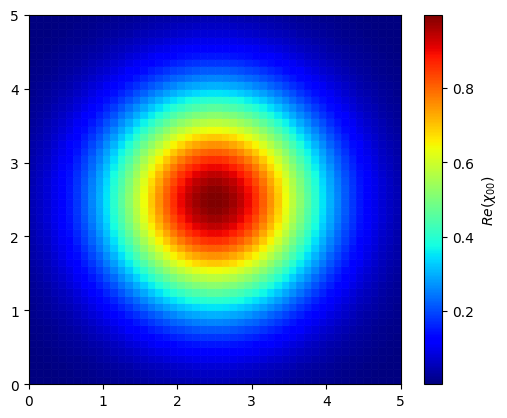

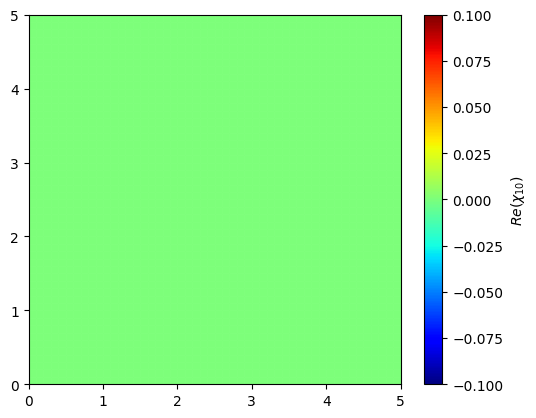

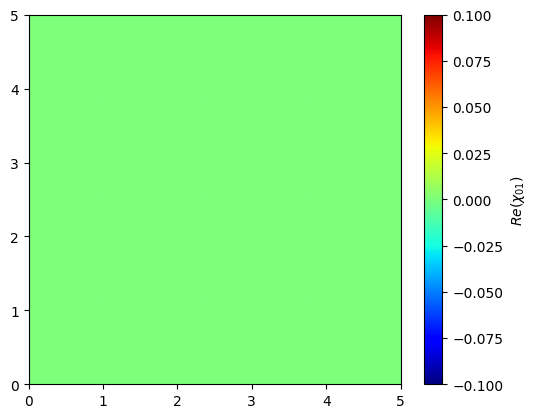

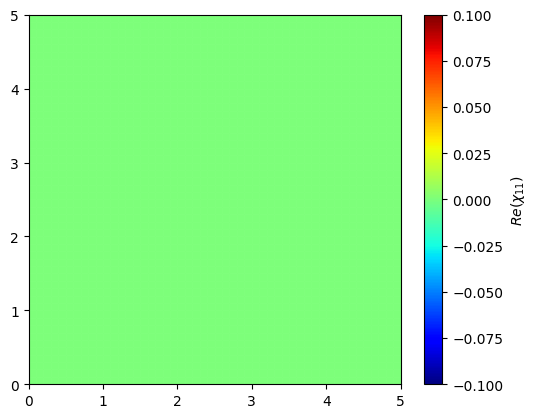

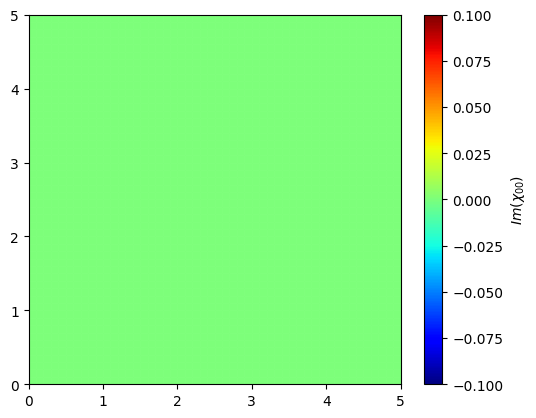

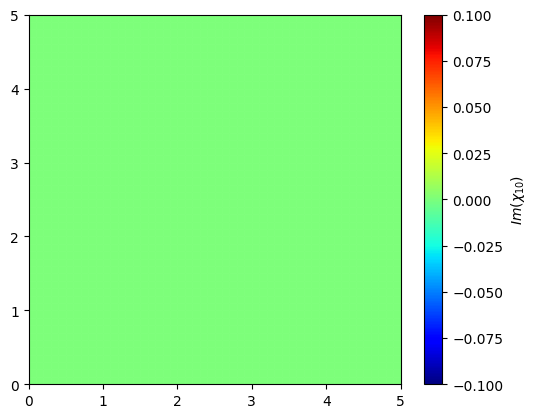

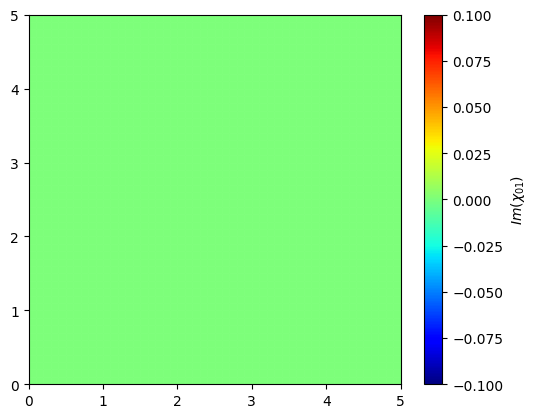

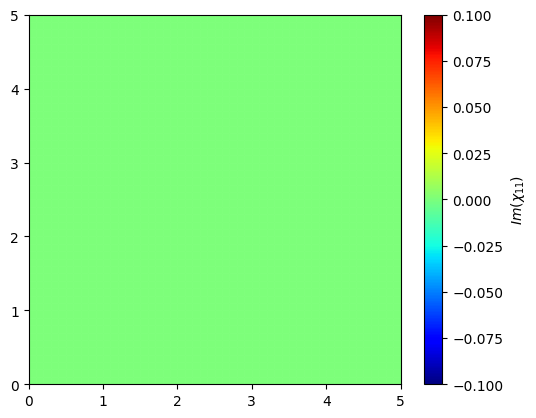

In [10]:
viewer1 = Viewer2D((chiR00))
viewer2 = Viewer2D((chiR10))
viewer3 = Viewer2D((chiR01))
viewer4 = Viewer2D((chiR11))

viewera = Viewer2D((chiI00))
viewerb = Viewer2D((chiI10))
viewerc = Viewer2D((chiI01))
viewerd = Viewer2D((chiI11))

In [11]:
from builtins import range
chiR11_T = []
chiR10_T = []
chiR01_T = []
chiR00_T = []

chiI11_T = []
chiI10_T = []
chiI01_T = []
chiI00_T = []
for t in range(4000):
    chiR11.updateOld()
    chiR10.updateOld()
    chiR01.updateOld()
    chiR00.updateOld()
    
    chiI11.updateOld()
    chiI10.updateOld()
    chiI01.updateOld()
    chiI00.updateOld()
    
    eqn.solve(dt=1.e-3)
    
    
    chiR11_T.append(CellVariable(mesh=mesh, value=chiR11.value))
    chiR10_T.append(CellVariable(mesh=mesh, value=chiR10.value))
    chiR01_T.append(CellVariable(mesh=mesh, value=chiR01.value))
    chiR00_T.append(CellVariable(mesh=mesh, value=chiR00.value))
    
    chiI11_T.append(CellVariable(mesh=mesh, value=chiI11.value))
    chiI10_T.append(CellVariable(mesh=mesh, value=chiI10.value))
    chiI01_T.append(CellVariable(mesh=mesh, value=chiI01.value))
    chiI00_T.append(CellVariable(mesh=mesh, value=chiI00.value))
    
    #viewer.plot()


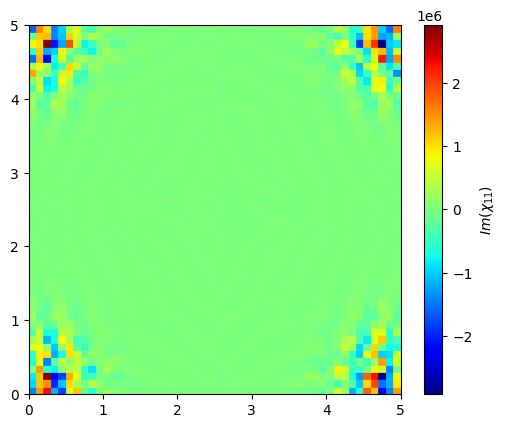

In [12]:
viewerd.plot()

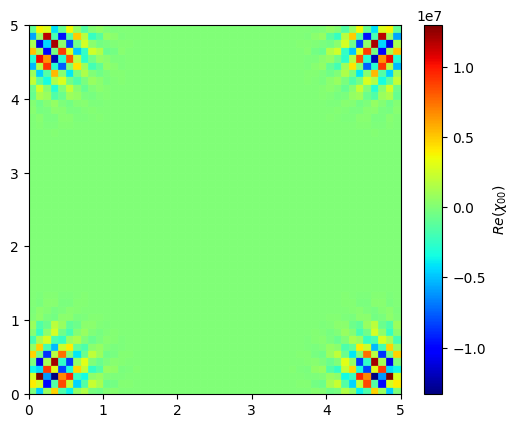

In [13]:
viewer1.plot()

In [14]:
np.save('chiR11_T.npy', chiR11_T)
np.save('chiR10_T.npy', chiR10_T)
np.save('chiR01_T.npy', chiR01_T)
np.save('chiR00_T.npy', chiR00_T)

np.save('chiI11_T.npy', chiI11_T)
np.save('chiI10_T.npy', chiI10_T)
np.save('chiI01_T.npy', chiI01_T)
np.save('chiI00_T.npy', chiI00_T)

In [15]:
chiR11_T = np.load('chiR11_T.npy')
chiR10_T = np.load('chiR10_T.npy')
chiR01_T = np.load('chiR01_T.npy')
chiR00_T = np.load('chiR00_T.npy')

chiI11_T = np.load('chiI11_T.npy')
chiI10_T = np.load('chiI10_T.npy')
chiI01_T = np.load('chiI01_T.npy')
chiI00_T = np.load('chiI00_T.npy')

In [16]:
CHI00_beta_zero = chiR00_T[:,index_where_1[0][0]]+chiI00_T[:,index_where_1[0][0]]*1.0j
CHI01_beta_zero = chiR01_T[:,index_where_1[0][0]]+chiI01_T[:,index_where_1[0][0]]*1.0j
CHI10_beta_zero = chiR10_T[:,index_where_1[0][0]]+chiI10_T[:,index_where_1[0][0]]*1.0j
CHI11_beta_zero = chiR11_T[:,index_where_1[0][0]]+chiI11_T[:,index_where_1[0][0]]*1.0j

In [17]:
def abs2(x):
    return x.real**2 + x.imag**2
E_B = omega_0*CHI11_beta_zero
ergotr_B_by_omega = (0.5)*(np.sqrt(np.square(CHI11_beta_zero-CHI00_beta_zero)+4*abs2(CHI10_beta_zero))+CHI11_beta_zero-CHI00_beta_zero)

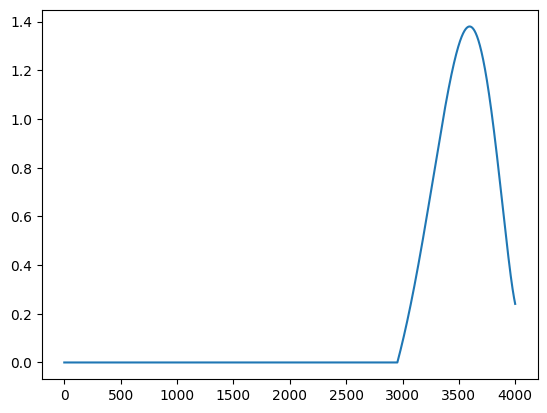

In [18]:
plt.plot(ergotr_B_by_omega.real)
plt.show()

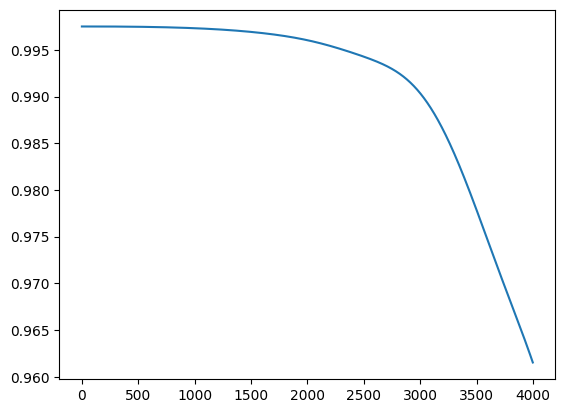

In [19]:
condition1 =  CHI11_beta_zero.real+ CHI00_beta_zero.real
condition2 = CHI11_beta_zero.imag+CHI00_beta_zero.imag 
plt.plot(condition1)
plt.show()

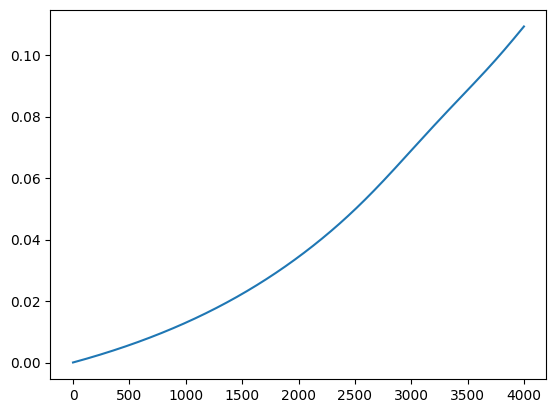

In [20]:
plt.plot(condition2)
plt.show()

In [21]:
eq1R = 2*F*(x-(nx*dx)/2)*chiI00+1/4*g*numerix.square(x-(nx*dx)/2)*chiI01-1/4*g*numerix.square(y-(ny*dy)/2)*chiI01-1/4*g*numerix.square(x-(nx*dx)/2)*chiI10+1/4*g*numerix.square(y-(ny*dy)/2)*chiI10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR00+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR00-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR10+(chiR00^(0,0,1))-1/2*g*(y-(ny*dy)/2)*chiI01.grad[1]+1/2*g*(y-(ny*dy)/2)*chiI10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR00.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR10.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI01.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI10.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI01.grad[0]-1/2*g*(x-(nx*dx)/2)*chiI10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*(chiR00.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiR01.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiR10.grad[0])-1/2*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[0]
eq1I = 1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI00+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI00-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI10-2*F*(x-(nx*dx)/2)*chiR00-1/4*g*numerix.square(x-(nx*dx)/2)*chiR01+1/4*g*numerix.square(y-(ny*dy)/2)*chiR01+1/4*g*numerix.square(x-(nx*dx)/2)*chiR10-1/4*g*numerix.square(y-(ny*dy)/2)*chiR10+(chiI00^(0,0,1))+1/2*gamma*(y-(ny*dy)/2)*chiI00.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI10.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR01.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR10.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR01.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR10.faceValue).divergence.grad[1]+1/2*gamma*(x-(nx*dx)/2)*(chiI00.grad[0])-1/2*g*(y-(ny*dy)/2)*(chiI01.grad[0])-1/2*g*(y-(ny*dy)/2)*chiI10.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR10.grad[0]-1/2*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[0]

eq2R = -(1/4)*g*numerix.square(x-(nx*dx)/2)*chiI00+1/4*g*numerix.square(y-(ny*dy)/2)*chiI00+2*F*(x-(nx*dx)/2)*chiI10+1/4*g*numerix.square(x-(nx*dx)/2)*chiI11-1/4*g*numerix.square(y-(ny*dy)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR10+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR10-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR11+(chiR10^(0,0,1))-1/2*g*(y-(ny*dy)/2)*chiI00.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI00.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI11.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI00.grad[0]+1/2*g*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[0]+1/2*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[0]
eq2I = 1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI10+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI10-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI11+1/4*g*numerix.square(x-(nx*dx)/2)*chiR00-1/4*g*numerix.square(y-(ny*dy)/2)*chiR00-2*F*(x-(nx*dx)/2)*chiR10-1/4*g*numerix.square(x-(nx*dx)/2)*chiR11+1/4*g*numerix.square(y-(ny*dy)/2)*chiR11+(chiI10^(0,0,1))-1/2*g*(x-(nx*dx)/2)*chiI00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR00.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR11.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR00.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR11.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[0]+1/2*g*(numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[0]

eq3R = 1/4*g*numerix.square(x-(nx*dx)/2)*chiI00-1/4*g*numerix.square(y-(ny*dy)/2)*chiI00+2*F*(x-(nx*dx)/2)*chiI01-1/4*g*numerix.square(x-(nx*dx)/2)*chiI11+1/4*g*numerix.square(y-(ny*dy)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR01+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR11+(chiR01^(0,0,1))+1/2*g*(y-(ny*dy)/2)*chiI00.grad[1]+1/2*g*(y-(ny*dy)/2)*chiI11.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR11.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI00.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI11.faceValue).divergence.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI00.grad[0]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR01.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[0]-1/2*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[0]
eq3I = 1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI00+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI01+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI01-1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI11-1/4*g*numerix.square(x-(nx*dx)/2)*chiR00+1/4*g*numerix.square(y-(ny*dy)/2)*chiR00-2*F*(x-(nx*dx)/2)*chiR01+1/4*g*numerix.square(x-(nx*dx)/2)*chiR11-1/4*g*numerix.square(y-(ny*dy)/2)*chiR11+(chiI01^(0,0,1))-1/2*g*(x-(nx*dx)/2)*chiI00.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI01.grad[1]-1/2*g*(x-(nx*dx)/2)*chiI11.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR00.grad[1]-1/2*g*(y-(ny*dy)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR00.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR11.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI00.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI01.grad[0]-1/2*g*(y-(ny*dy)/2)*chiI11.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR00.grad[0]+1/2*g*(x-(nx*dx)/2)*chiR11.grad[0]-1/2*g*numerix.dot([[1],[0]], chiI00.faceValue).divergence.grad[1]-1/2*g*numerix.dot([[1],[0]], chiI11.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiR00.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiR11.faceValue).divergence.grad[0]

eq4R = -(1/4)*g*numerix.square(x-(nx*dx)/2)*chiI01+1/4*g*numerix.square(y-(ny*dy)/2)*chiI01+1/4*g*numerix.square(x-(nx*dx)/2)*chiI10-1/4*g*numerix.square(y-(ny*dy)/2)*chiI10+2*F*(x-(nx*dx)/2)*chiI11+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR01+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiR10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiR11+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiR11+(chiR11^(0,0,1))-1/2*g*(y-(ny*dy)/2)*chiI01.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI10.grad[1]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[1]+1/2*g*(x-(nx*dx)/2)*chiR10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiR11.grad[1]+1/4*g*numerix.dot([[0],[1]], chiI01.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[0],[1]], chiI10.faceValue).divergence.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI01.grad[0]+1/2*g*(x-(nx*dx)/2)*chiI10.grad[0]-1/2*g*(y-(ny*dy)/2)*chiR01.grad[0]+1/2*g*(y-(ny*dy)/2)*chiR10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiR11.grad[0]+1/2*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[1]+1/2*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[1]-1/4*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[0]+1/4*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[0]
eq4I = 1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI01+1/2*g*(x-(nx*dx)/2)*(y-(ny*dy)/2)*chiI10+1/2*gamma*numerix.square(x-(nx*dx)/2)*chiI11+1/2*gamma*numerix.square(y-(ny*dy)/2)*chiI11+1/4*g*numerix.square(x-(nx*dx)/2)*chiR01-1/4*g*numerix.square(y-(ny*dy)/2)*chiR01-1/4*g*numerix.square(x-(nx*dx)/2)*chiR10+1/4*g*numerix.square(y-(ny*dy)/2)*chiR10-2*F*(x-(nx*dx)/2)*chiR11+(chiI11^(0,0,1))-1/2*g*(x-(nx*dx)/2)*chiI01.grad[1]+1/2*g*(x-(nx*dx)/2)*chiI10.grad[1]+1/2*gamma*(y-(ny*dy)/2)*chiI11.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR01.grad[1]+1/2*g*(y-(ny*dy)/2)*chiR10.grad[1]-1/4*g*numerix.dot([[0],[1]], chiR01.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[0],[1]], chiR10.faceValue).divergence.grad[1]-1/2*g*(y-(ny*dy)/2)*chiI01.grad[0]+1/2*g*(y-(ny*dy)/2)*chiI10.grad[0]+1/2*gamma*(x-(nx*dx)/2)*chiI11.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR01.grad[0]-1/2*g*(x-(nx*dx)/2)*chiR10.grad[0]+1/2*g*numerix.dot([[1],[0]], chiI01.faceValue).divergence.grad[1]+1/2*g*numerix.dot([[1],[0]], chiI10.faceValue).divergence.grad[1]+1/4*g*numerix.dot([[1],[0]], chiR01.faceValue).divergence.grad[0]-1/4*g*numerix.dot([[1],[0]], chiR10.faceValue).divergence.grad[0]


SyntaxError: '(' was never closed (869580747.py, line 5)